In [1]:

%load_ext autoreload
%autoreload 2
import bnl
from bnl import viz

## Let's plot!

- Figure 1: how framesize affect the triplet metrics
- Figure 2: how continuous compares with 0.5: scatter plot


1134-0
1134-1


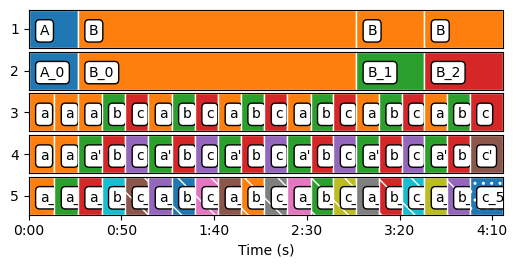

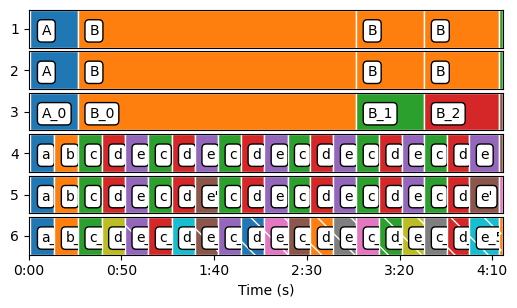

In [10]:
import random
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
while len(salami_hiers) < 2:
    tid = random.choice(tids)
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)

hiers = {'-'.join([str(tid), str(i)]): h for i, h in enumerate(salami_hiers)}

for tid, h in hiers.items():
    print(tid)
    h.expand(format='slm', always_include=False).plot();

## Comparing Mir_eval implementation and my implementation


### Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [ ]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import metrics
import os
from pqdm.processes import pqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Create output directory if it doesn't exist
os.makedirs("./compare_implementation", exist_ok=True)

# Determine number of CPU cores to use
n_jobs = max(1, os.cpu_count() - 1)  # Leave one CPU free

# Process tracks in parallel
tids = bnl.fio.salami_tids()
pqdm(tids, metrics.time_salami_track, n_jobs=n_jobs);

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [19]:
## Time to collect
from glob import glob
from tqdm import tqdm
import os
import xarray as xr


In [23]:
results_fpaths = glob('./compare_implementation/*.nc')

das = []
for fp in tqdm(results_fpaths):
    tid = os.path.basename(fp).split('.')[0]
    # Load the data array and assign the tid as a coordinate
    da = xr.open_dataarray(fp)
    da = da.assign_coords(tid=tid)
    da = da.expand_dims('tid')
    das.append(da)

# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')


100%|██████████| 882/882 [00:07<00:00, 123.56it/s]


In [ ]:
#  Save the final data array to a NetCDF file
final_da.to_netcdf('./compare_implementation.nc')


### Alright, I can load from saved data now. Now let's do scatter plot to see how they differ

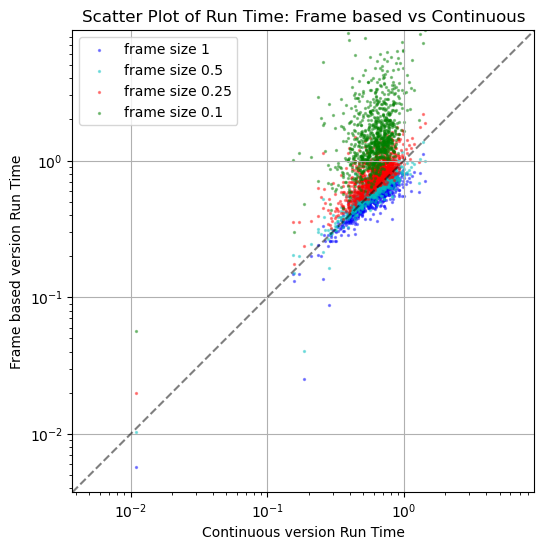

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# Load the data array from the NetCDF file
results = xr.open_dataarray('./compare_implementation.nc')
results.name = 'run_time'

# Convert the xarray DataArray to a pandas DataFrame
df = results.to_dataframe().reset_index()

# Group by 'tid' and 'frame_size' and calculate the mean run_time
df_grouped = df.groupby(['tid', 'frame_size'])['run_time'].mean().reset_index()

# Pivot the DataFrame to have 'run_time' for each 'frame_size' as columns
df_pivot = df_grouped.pivot(index='tid', columns='frame_size', values='run_time')

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot the run times for different frame sizes against frame size 0.0
ax.scatter(df_pivot[0.0], df_pivot[1], alpha=0.4, s=2, label='frame size 1', color='b')
ax.scatter(df_pivot[0.0], df_pivot[0.5], alpha=0.4, s=2, label='frame size 0.5', color='c')
ax.scatter(df_pivot[0.0], df_pivot[0.25], alpha=0.4,  s=2, label='frame size 0.25', color='r')
ax.scatter(df_pivot[0.0], df_pivot[0.1], alpha=0.4,  s=2, label='frame size 0.1', color='g')

# Set the axis labels and title
ax.set_xlabel('Continuous version Run Time')
ax.set_ylabel('Frame based version Run Time')
ax.set_title('Scatter Plot of Run Time: Frame based vs Continuous')

# Add a legend and grid
ax.legend()
ax.grid(True)

ax.set_xscale('log')
ax.set_yscale('log')
min_v = df_pivot.min().min()
max_v = df_pivot.max().max()
ax.set_xlim(min_v, max_v)
ax.set_ylim(min_v, max_v)

# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

# Plot a diagonal line for reference
ax.plot([min_v,max_v],[min_v,max_v], linestyle='--', color='k', alpha=0.5)

# Show the plot
plt.show();




In [99]:
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

def plot_scatter_frame_vs_continuous(results, output_type='run_time', frame_sizes = [0.1, 0.25, 0.5, 1, 2], ax=None):
    """
    Generates a scatter plot comparing the performance of frame-based vs. continuous
    implementations for a given output type (e.g., 'run_time', 'lm').

    Args:
        results (xr.DataArray): An xarray DataArray containing the results,
            with dimensions 'tid', 'frame_size', and 'output'.
        output_type (str): The type of output to plot (e.g., 'run_time', 'lm').
        ax (matplotlib.axes._axes.Axes, optional): An existing matplotlib Axes
            object to plot on. If None, a new figure and axes will be created.
            Defaults to None.

    Returns:
        matplotlib.axes._axes.Axes: The Axes object containing the plot.
    """

    # Filter the xarray DataArray to only include the desired output type
    results_filtered = results.sel(output=output_type)
    results_filtered.name = output_type
    # return results_filtered
    # Convert the filtered xarray DataArray to a pandas DataFrame
    df = results_filtered.to_dataframe().reset_index()
    # Group by 'tid' and 'frame_size' and calculate the mean for the specified output type
    df_grouped = df.groupby(['tid', 'frame_size'])[output_type].mean().reset_index()
    # Pivot the DataFrame to have the specified output type for each 'frame_size' as columns
    df_pivot = df_grouped.pivot(index='tid', columns='frame_size', values=output_type)

    # Create the scatter plot if ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 5))

    for frame_size in frame_sizes:
        if frame_size not in df_pivot.columns:
            raise ValueError(f"Frame size {frame_size} not found in the data.")
        
        ax.scatter(
            df_pivot[0.0], 
            df_pivot[frame_size], 
            alpha=0.4, s=2, label=f'frame size {frame_size:.1f} sec'
        )

    # Set the axis labels and title
    ax.set_xlabel('Continuous version ' + output_type)
    ax.set_ylabel('Frame based version ' + output_type)
    ax.set_title(output_type)

    # Add a legend and grid
    ax.legend()
    ax.grid(True)
    
    if df_pivot.max().max() > 2:
        ax.set_xscale('log')
        ax.set_yscale('log')
        min_v = df_pivot.min().min()
        max_v = df_pivot.max().max()

    else:
        min_v , max_v = 0, 1
    
    ax.set_xlim(min_v, max_v)
    ax.set_ylim(min_v, max_v)
    # Set the aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')

    # Plot a diagonal line for reference
    ax.plot([min_v,max_v],[min_v,max_v], linestyle='--', color='k', alpha=0.5)

    return ax


In [100]:

# Load the data array from the NetCDF file
results = xr.open_dataarray('./compare_implementation.nc')


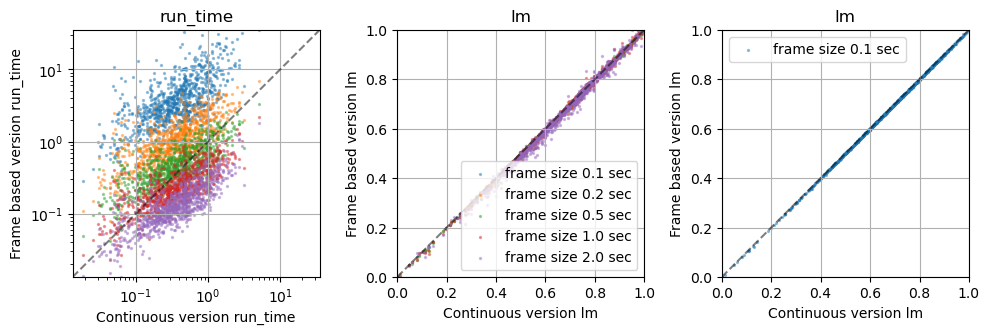

In [104]:
import numpy as np

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot a square on each subplot

plot_scatter_frame_vs_continuous(results, output_type='run_time', ax=axes[0])
plot_scatter_frame_vs_continuous(results, output_type='lm', ax=axes[1])
plot_scatter_frame_vs_continuous(results, output_type='lm', frame_sizes=[0.1], ax=axes[2])
axes[0].legend().remove()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('./compare_implementation.pdf')

In [ ]:
# now we have the results. Let's see run time for each implementation
# 6 colors for 6 frame sizes. I want to compare run time for each implementation.
# lets use scatter plot between 2 implementations


<xarray.DataArray (tid: 882, frame_size: 6, output: 4)> Size: 169kB
[21168 values with dtype=float64]
Coordinates:
  * tid         (tid) object 7kB '429' '18' '538' '478' ... '6' '99' '628' '768'
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.25 0.5 1.0 2.0
  * output      (output) object 32B 'run_time' 'lp' 'lr' 'lm'

## Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [ ]:
import xarray as xr
import os
from tqdm import tqdm
test_frame_size = [0, 0.1, 0.25, 0.5, 1, 2]
da_coords = dict(frame_size=test_frame_size, output=['run_time', 'lp', 'lr', 'lm'])
result_da = xr.DataArray(dims=da_coords.keys(), coords=da_coords)

# Let's just save for each track independently
for tid in tqdm(tids):
    hiers = bnl.fio.salami_ref_hiers(tid=tid)
    if len(hiers) < 2:
        continue
    fname = f"./compare_implementation/{tid}.nc"
    if os.path.exists(fname):
        continue
    # Get the two hierarchies
    ref = hiers[0]
    est = hiers[1]
    for frame_size in test_frame_size:
        # Measure time for both implementations
        run_time, results = metrics.time_lmeasure(ref, est, frame_size=frame_size)
        result_da.loc[dict(frame_size=frame_size)] = [run_time, *results]
    # save the results
    result_da.to_netcdf(f"./compare_implementation/{tid}.nc")

  3%|▎         | 45/1359 [01:44<50:49,  2.32s/it]  


In [73]:
result_da.sel(tid='10', output='lr')

<xarray.DataArray (frame_size: 6)> Size: 48B
array([0.48241948, 0.48227406, 0.4807845 , 0.4793945 , 0.47822971,
       0.48374867])
Coordinates:
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.25 0.5 1.0 2.0
    tid         <U4 16B '10'
    output      <U8 32B 'lr'

In [69]:
result_da.sel(tid='10', output='lr')

<xarray.DataArray (frame_size: 6)> Size: 48B
array([0.48241948, 0.48227406, 0.4807845 , 0.4793945 , 0.47822971,
       0.48374867])
Coordinates:
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.25 0.5 1.0 2.0
    tid         <U4 16B '10'
    output      <U8 32B 'lr'

(<Figure size 500x250 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>],
       dtype=object))

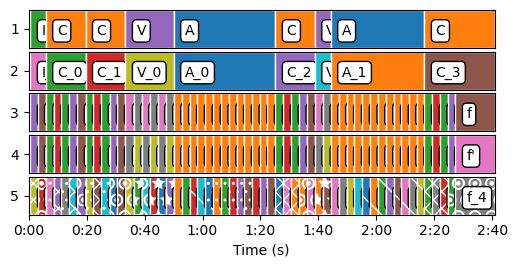

In [88]:
h = bnl.levels2H(h.levels)
h.expand().plot()

## Let's investigate!

- Transitivity, and effects of depth.
- Window and its effects. (It's faster now so we probably don't need it. Let's check the original claim that over all frames are redundant)
    - We can visualize this by looking at how window size affect the per time measures.
- Monotonicity Meet and its effect.
    - Again look at per time measures and how they change before and after.



In [4]:
tids = bnl.fio.salami_tids()
hiers = bnl.fio.salami_ref_hiers(tid=tids[0])
hiers

[<bnl.core.H at 0x12a6e7c40>, <bnl.core.H at 0x12a58b520>]

(<Figure size 500x130 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

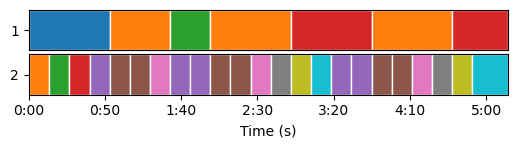

In [8]:
hiers[0].plot(text=False)